In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('custom_modules')

import Data_processing as dp

from IPython.display import display
from matplotlib import ticker
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Пути к X части выборки с массивами в каждой ячейке
path_to_array_like_X_data = 'data/Prepared data/Run1/X_data_array_like.xlsx'
# Пути к Y части выборки
path_to_Y_data = 'data/Prepared data/Run1/Y_data(binary_classification).xlsx'


### Константы для обработки данных

In [3]:
PREP_image_size = 64
PREP_crop_step = 2

In [4]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

# Подготовка данных

In [5]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

X_dict['df'] =  dp.get_array_like_X_df(path_to_array_like_X_data)
Y_dict['df'] =  dp.get_Y_df(path_to_Y_data)

X_dict['df'] = pd.concat([X_dict['df'].iloc[:,200:],X_dict['df'].iloc[:,:200]],axis=1,ignore_index=True)
Y_dict['df'] = pd.concat([Y_dict['df'].iloc[:,200:],Y_dict['df'].iloc[:,:200]],axis=1,ignore_index=True)

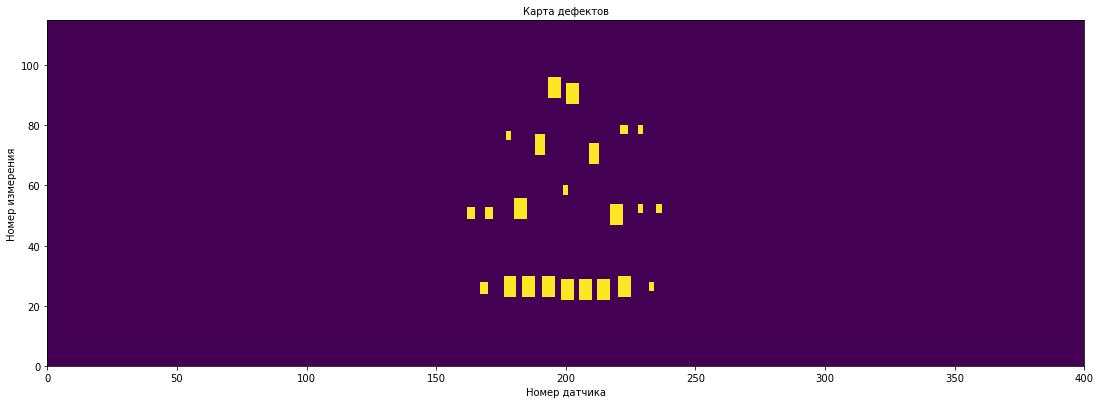

In [6]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])

axes.set_xlabel('Номер датчика', fontsize=10) 
axes.set_ylabel('Номер измерения', fontsize=10) 
axes.set_title(f'Карта дефектов', fontsize=10) 
     
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

In [7]:
# добавление строк в датафреймы
print('||||||||||| X df preprocessing |||||||||||')
print('Original df size: ', X_dict['df'] .shape)
#X_dict['df'] = pd.concat([X_dict['df'],X_dict['df'].iloc[:,:64]],axis=1,ignore_index=True)
#X_dict['df'] = pd.concat([X_dict['df'],X_dict['df'].iloc[:64,:]],axis=0,ignore_index=True)
print('Result df size: ', X_dict['df'] .shape)
X_dict['df'] = dp.reshape_df_for_future_crops(X_dict['df'], 
                                                        PREP_image_size, 
                                                        PREP_crop_step)

print('||||||||||| Y df preprocessing |||||||||||')
print('Original df size: ', Y_dict['df'].shape)
#Y_dict['df'] = pd.concat([Y_dict['df'],Y_dict['df'].iloc[:,:64]],axis=1,ignore_index=True)
#Y_dict['df'] = pd.concat([Y_dict['df'],Y_dict['df'].iloc[:64,:]],axis=0,ignore_index=True)
print('Original df size: ', Y_dict['df'].shape)
Y_dict['df'] = dp.reshape_df_for_future_crops(Y_dict['df'], 
                                                        PREP_image_size, 
                                                        PREP_crop_step)

print('\n')

||||||||||| X df preprocessing |||||||||||
Original df size:  (115, 400)
Result df size:  (115, 400)
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  2
New df shape:  (116, 400)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
Original df size:  (115, 400)
Original df size:  (115, 400)
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  2
New df shape:  (116, 400)
||||||||||||||||||





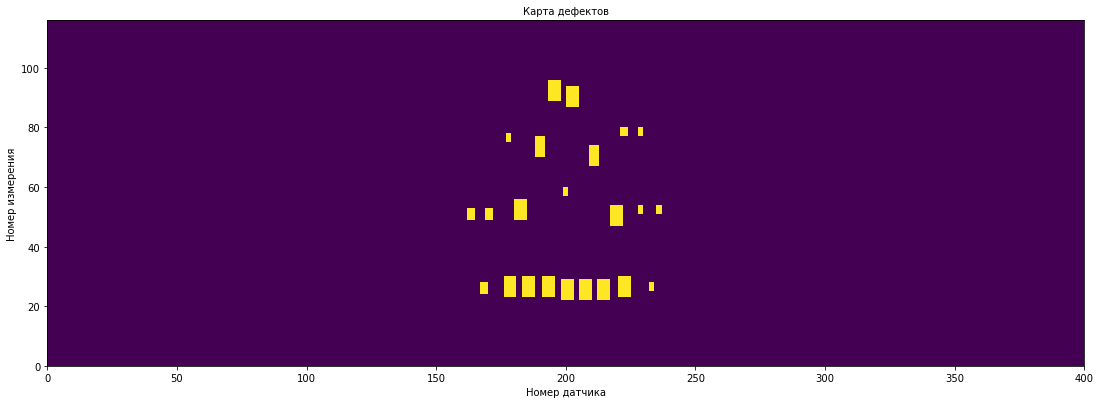

In [8]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])

axes.set_xlabel('Номер датчика', fontsize=10) 
axes.set_ylabel('Номер измерения', fontsize=10) 
axes.set_title(f'Карта дефектов', fontsize=10) 
     
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

In [9]:
# запишем в словарь numpy array полученные из df

print('||||||||||| X df preprocessing |||||||||||')
x_time_temp, \
x_amp_temp = dp.reshape_X_df_to_image_like_numpy(X_dict['df'], 
                                                    PREP_image_size, 
                                                    PREP_crop_step)
X_dict['X_time_all'] = x_time_temp.astype('float32')
X_dict['X_amp_all'] = x_amp_temp.astype('float32')

X_dict.pop('df',0)

print('||||||||||| Y df preprocessing |||||||||||')
y_temp = dp.reshape_Y_df_to_image_like_numpy(Y_dict['df'], 
                                             PREP_image_size, 
                                             PREP_crop_step)
Y_dict['Y_mask_all'] = y_temp.astype('int8')

Y_dict.pop('df',0)

print('\n')
    
    

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (116, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  2
New X_time shape:  (4563, 64, 64, 32)
New X_amp shape:  (4563, 64, 64, 32)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Y df reshaping to 3D
Original df size:  (116, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  2
New numpy shape:  (4563, 64, 64, 1)
||||||||||||||||||





In [10]:
print('||||||||||||||||||||||||||||')
print('\n||||||||||| X data |||||||||||')
print(f'Для \"X\" выборки считано ', X_dict.keys())

print('\n||||||||||| Y data |||||||||||')        
print(f'Для \"Y\" выборки считано ', Y_dict.keys())

||||||||||||||||||||||||||||

||||||||||| X data |||||||||||
Для "X" выборки считано  dict_keys(['X_time_all', 'X_amp_all'])

||||||||||| Y data |||||||||||
Для "Y" выборки считано  dict_keys(['Y_mask_all'])


In [11]:
# обработка данных
print('||||||||||| X df preprocessing |||||||||||')

(X_time_def, X_time_non_def), \
(X_amp_def, X_amp_non_def), \
(Y_mask_def, Y_mask_non_def), \
(Y_binary_def, Y_binary_non_def) = dp.preprocess_data(X_dict['X_time_all'], 
                                                            X_dict['X_amp_all'], 
                                                            Y_dict['Y_mask_all'],
                                                            PREP_image_size)

X_dict['X_time_def'] = X_time_def
X_dict['X_time_non_def'] = X_time_non_def

X_dict['X_amp_def'] = X_amp_def
X_dict['X_amp_non_def'] = X_amp_non_def

Y_dict['Y_binary_def'] = Y_binary_def
Y_dict['Y_binary_non_def'] = Y_binary_non_def

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Data preprocessing
Orig X_time shape:  (4563, 64, 64, 32)
Orig X_amp shape:  (4563, 64, 64, 32)
Orig Y_mask shape:  (4563, 64, 64, 1)
||||||||||||||||||
Data standartization
X_time_max: 44.5
X_amp_max: 62.992000579833984

X_time_max after standartization: 1.0
X_time_min after standartization: 0.0

X_amp_max after standartization: 1.0
X_amp_min after standartization: -0.9837439060211182
||||||||||||||||||

||||||||||||||||||
Data with and witout defects splitting
||||||||||||||||||
Defects nums calculating
Для карт высотой и шириной в 64
и общим кличеством: 4563
дефекты присутствуеют на 1863 картах
||||||||||||||||||

X_time_def shape:  (1863, 64, 64, 32)
X_time_non_def shape:  (2700, 64, 64, 32)

X_amp_def shape:  (1863, 64, 64, 32)
X_amp_non_def shape:  (2700, 64, 64, 32)

Y_mask_def shape:  (1863, 64, 64, 1)
Y_mask_non_def shape:  (2700, 64, 64, 1)

Y_binary_def shape:  (1863,)
Y_binary_non_def shape:  (2700,)
||||||||||||

In [12]:
# очистка памяти от лишнего

X_dict.pop('X_time_all',0)
X_dict.pop('X_amp_all',0)
Y_dict.pop('Y_mask_all',0)

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [13]:
print('||||||||||||||||||||||||||||')
print('\n||||||||||| X data |||||||||||')
print(f'Для \"X\" выборки считано ', X_dict.keys())

print('\n||||||||||| Y data |||||||||||')        
print(f'Для \"Y\" выборки считано ', Y_dict.keys())

||||||||||||||||||||||||||||

||||||||||| X data |||||||||||
Для "X" выборки считано  dict_keys(['X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])

||||||||||| Y data |||||||||||
Для "Y" выборки считано  dict_keys(['Y_binary_def', 'Y_binary_non_def'])


In [14]:
print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"{key}.shape: ", X_dict[key].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"{key}.shape: ", Y_dict[key].shape)

|||||||||||||| X dataset ||||||||||||||||
X_time_def.shape:  (1863, 64, 64, 32)
X_time_non_def.shape:  (2700, 64, 64, 32)
X_amp_def.shape:  (1863, 64, 64, 32)
X_amp_non_def.shape:  (2700, 64, 64, 32)

|||||||||||||| Y dataset ||||||||||||||||
Y_binary_def.shape:  (1863,)
Y_binary_non_def.shape:  (2700,)


In [15]:
X_time_test = np.concatenate([X_dict['X_time_def'],
                              X_dict['X_time_non_def']],
                              axis=0)
                              
X_dict.pop('X_time_def',0)
X_dict.pop('X_time_non_def',0)


X_amp_test = np.concatenate([X_dict['X_amp_def'],
                             X_dict['X_amp_non_def']],
                             axis=0)

X_dict.pop('X_amp_def',0)
X_dict.pop('X_amp_non_def',0)


Y_binary_test = np.concatenate([Y_dict['Y_binary_def'],
                               Y_dict['Y_binary_non_def']],
                               axis=0)

Y_dict.pop('Y_binary_def',0)
Y_dict.pop('Y_binary_non_def',0)

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
# очистка памяти от лишнего        
X_dict.clear()
Y_dict.clear()

In [17]:
print('X_time_test.shape: ', X_time_test.shape)
print('X_amp_test.shape: ', X_amp_test.shape)
print('Y_binary_test.shape', Y_binary_test.shape)
print('\n')

X_time_test.shape:  (4563, 64, 64, 32)
X_amp_test.shape:  (4563, 64, 64, 32)
Y_binary_test.shape (4563,)




# CNN с 1 входом по времени

In [18]:
model = keras.models.load_model('Networks//CNN//NetWork_(64x32+64x32)_to(1)_(test_0dot1996).h5')

In [19]:
# тест модели
model.evaluate([X_time_test,X_amp_test], Y_binary_test, batch_size = 1)
#700 + 
# 1200 - 
# 2100 + 
# 2400 - 
# 2900 + 

4563/4563 [==============================] - 130s 28ms/step - loss: 0.1354


0.13538408279418945

In [ ]:
res = model.predict([X_time_test,X_amp_test])

 18/143 [==>...........................] - ETA: 1:05

In [ ]:
print(res.shape)
res_arr = np.zeros(res.shape[0])
print(res_arr.shape)
res_arr[:] = res[:,0]
print(res_arr.shape)
res_arr = np.around(res_arr)

In [ ]:
def int_to_float32_matrix(num,crop_size):
    return np.full((crop_size, crop_size), num, dtype='float32')

In [ ]:
def create_defects_map(res_arr,rows,cols,crop_size,step):

    new_arr = np.full((rows, cols), 0, dtype='float32')
    myit = iter(res_arr)

    for i in range(0,rows - crop_size + 1, step):
        for j in range(0,cols - crop_size + 1, step):
            temp = next(myit)
            if temp == 1:
                new_arr[i:i+crop_size,j:j+crop_size] = new_arr[i:i+crop_size,j:j+crop_size] + 0.1
            if temp == 0:
                new_arr[i:i+crop_size,j:j+crop_size] = new_arr[i:i+crop_size,j:j+crop_size] - 0.1
                
    return new_arr

In [ ]:
map_1 = create_defects_map(res_arr, 116, 400, PREP_image_size, PREP_crop_step)

In [ ]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(map_1)

axes.set_xlabel('Номер датчика', fontsize=10) 
axes.set_ylabel('Номер измерения', fontsize=10) 
axes.set_title(f'Карта дефектов', fontsize=10) 
     
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()